## Here, we used new training data generated using a new dispersion that has been updated with the scale factor found by previous models, and generate one set of models with peak information as features and one with spec points as features.


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

In [2]:
#Load the training data

subset = 5

peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
energy_names2 = energy_names[50::subset]

col_names2 = ['deltaI', 'deltaR','t1', 't2', 't3']+ peak_names + locs_names + width_names + prom_names

col_names1 = ['deltaI', 'deltaR','t1', 't2', 't3'] + energy_names

col_names_both = col_names2 + energy_names2



data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071018_v9_specPoints.csv', header = None, names = col_names1)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071018_v9_peakinfo.csv', header = None, names = col_names2)

col_names1a = ['deltaI', 'deltaR','t1', 't2', 't3'] + energy_names[50:]
data1 = data1[col_names1a]
data = data2.join(data1.drop(['deltaI', 'deltaR','t1', 't2', 't3'], axis = 1), how = 'left')
data = data[col_names_both]

X1 = data1.drop(['deltaI', 'deltaR','t1', 't2', 't3'], axis = 1)
Y1 = data1[['deltaI', 'deltaR']]

X2 = data2.drop(['deltaI', 'deltaR', 'peak1','t1', 't2', 't3'], axis = 1)
Y2 = data2[['deltaI', 'deltaR']]

X = data.drop(['deltaI', 'deltaR', 'peak1','t1', 't2', 't3'], axis = 1)
Y = data[['deltaI', 'deltaR']]



ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

data.head()

,deltaI,deltaR,t1,t2,t3,peak1,peak2,peak3,peak4,loc1,...,E_410_mV,E_420_mV,E_430_mV,E_440_mV,E_450_mV,E_460_mV,E_470_mV,E_480_mV,E_490_mV,E_500_mV
0,0.81472,-0.147980,0.41370,0.43701,-8.6764,9.8822,5.5667,3.6113,2.7913,-0.398,...,1.14190,1.17720,1.09960,0.95553,0.81548,0.71202,0.64951,0.62416,0.63288,0.67559
1,0.09754,-1.133300,0.45569,0.44363,-5.3511,18.0630,16.8260,12.9150,9.8592,-0.378,...,3.18590,0.77408,0.33984,0.20589,0.15203,0.12789,0.11985,0.12397,0.14167,0.18740
2,0.15761,-0.046193,0.49672,0.37281,-6.9972,1.7381,1.4604,1.2477,1.1347,-0.292,...,1.10660,1.08610,1.06650,1.05040,1.03890,1.03090,1.02430,1.01690,1.00640,0.99171
3,0.14189,-0.908300,0.49257,0.41883,-5.4051,14.0020,12.3480,8.9410,6.3451,-0.304,...,4.10480,2.08640,0.75307,0.38860,0.25497,0.19406,0.16608,0.15569,0.15934,0.17833
4,0.65574,-1.514700,0.48591,0.44010,-8.2126,5.8682,4.4592,3.2560,2.4006,-0.302,...,0.43107,0.42027,0.44770,0.52159,0.66660,0.89856,1.12680,1.20690,1.32290,1.61830


In [62]:
data.head()

,deltaI,deltaR,t1,t2,t3,peak1,peak2,peak3,peak4,loc1,...,E_410_mV,E_420_mV,E_430_mV,E_440_mV,E_450_mV,E_460_mV,E_470_mV,E_480_mV,E_490_mV,E_500_mV
0,0.81472,-0.147980,0.41370,0.43701,-8.6764,9.8822,5.5667,3.6113,2.7913,-0.398,...,1.14190,1.17720,1.09960,0.95553,0.81548,0.71202,0.64951,0.62416,0.63288,0.67559
1,0.09754,-1.133300,0.45569,0.44363,-5.3511,18.0630,16.8260,12.9150,9.8592,-0.378,...,3.18590,0.77408,0.33984,0.20589,0.15203,0.12789,0.11985,0.12397,0.14167,0.18740
2,0.15761,-0.046193,0.49672,0.37281,-6.9972,1.7381,1.4604,1.2477,1.1347,-0.292,...,1.10660,1.08610,1.06650,1.05040,1.03890,1.03090,1.02430,1.01690,1.00640,0.99171
3,0.14189,-0.908300,0.49257,0.41883,-5.4051,14.0020,12.3480,8.9410,6.3451,-0.304,...,4.10480,2.08640,0.75307,0.38860,0.25497,0.19406,0.16608,0.15569,0.15934,0.17833
4,0.65574,-1.514700,0.48591,0.44010,-8.2126,5.8682,4.4592,3.2560,2.4006,-0.302,...,0.43107,0.42027,0.44770,0.52159,0.66660,0.89856,1.12680,1.20690,1.32290,1.61830


In [3]:
data1.head()

,deltaI,deltaR,t1,t2,t3,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.147980,0.41370,0.43701,-8.6764,0.23882,0.23152,0.22630,0.22276,0.22095,...,0.62323,0.62371,0.62546,0.62839,0.63288,0.63869,0.64565,0.65423,0.66432,0.67559
1,0.09754,-1.133300,0.45569,0.44363,-5.3511,0.13010,0.15006,0.17606,0.21197,0.26000,...,0.12581,0.12903,0.13200,0.13683,0.14167,0.14810,0.15516,0.16464,0.17402,0.18740
2,0.15761,-0.046193,0.49672,0.37281,-6.9972,1.62320,1.67220,1.70830,1.73080,1.73810,...,1.01510,1.01320,1.01100,1.00870,1.00640,1.00370,1.00110,0.99801,0.99497,0.99171
3,0.14189,-0.908300,0.49257,0.41883,-5.4051,6.39180,3.10470,1.76910,1.13750,0.79020,...,0.15534,0.15561,0.15664,0.15788,0.15934,0.16199,0.16514,0.16840,0.17335,0.17833
4,0.65574,-1.514700,0.48591,0.44010,-8.2126,4.93760,3.75580,2.78690,2.08610,1.60270,...,1.21800,1.23370,1.25490,1.28390,1.32290,1.36940,1.42420,1.48600,1.55150,1.61830


In [4]:
data2.head()

,deltaI,deltaR,t1,t2,t3,peak1,peak2,peak3,peak4,loc1,...,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,0.81472,-0.147980,0.41370,0.43701,-8.6764,9.8822,5.5667,3.6113,2.7913,-0.398,...,-0.232,-0.084,0.001877,0.009717,0.019692,0.029163,6.6222,5.34590,3.23250,2.25190
1,0.09754,-1.133300,0.45569,0.44363,-5.3511,18.0630,16.8260,12.9150,9.8592,-0.378,...,-0.124,0.072,0.003477,0.004698,0.007322,0.009501,18.0080,16.74500,12.80400,9.73970
2,0.15761,-0.046193,0.49672,0.37281,-6.9972,1.7381,1.4604,1.2477,1.1347,-0.292,...,0.110,0.386,0.042705,0.056824,0.079090,0.080406,1.0521,0.62049,0.36429,0.14303
3,0.14189,-0.908300,0.49257,0.41883,-5.4051,14.0020,12.3480,8.9410,6.3451,-0.304,...,0.060,0.308,0.005644,0.007879,0.010993,0.014262,13.9150,12.22200,8.78560,6.14070
4,0.65574,-1.514700,0.48591,0.44010,-8.2126,5.8682,4.4592,3.2560,2.4006,-0.302,...,0.038,0.262,0.012698,0.019628,0.026555,0.032085,5.6336,4.10670,2.83680,1.88050


# Using the Best Models on the Hexagon Data 

## Statsmodels

### Spec Points

 
RMSE on test data: 1.030803160147181 for  Delta I
R^2 Score on test data: -11.655102703401699 for Delta I
 
RMSE on test data: 0.8051500524366062 for  Delta R
R^2 Score on test data: -2.2092643849497557 for Delta R
The average residual for predict: 0.3115
Residual is this percent of predict range 0.643 %
The average residual for predict: 0.4421
Residual is this percent of predict range 1.285 %


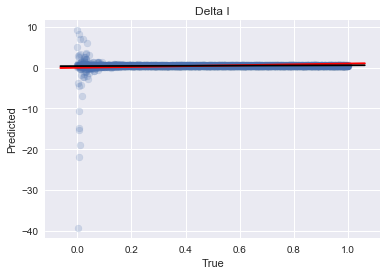

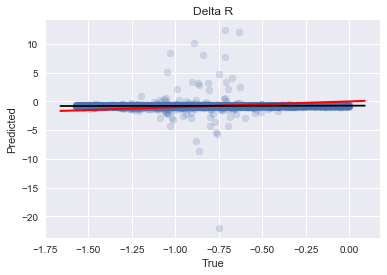

In [5]:
#Initialize and fit OLS model for deltaI 
model_OLS_I_sp = sm.OLS(Y1_train['deltaI'], X1_train)
model_OLS_R_sp = sm.OLS(Y1_train['deltaR'], X1_train)

results_OLS_I_sp = model_OLS_I_sp.fit()
results_OLS_R_sp = model_OLS_R_sp.fit()

#Make predictions on testing data
predictions_OLS_I_sp = results_OLS_I_sp.predict(X1_test) # make the predictions by the model
predictions_OLS_R_sp = results_OLS_R_sp.predict(X1_test)

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y1_test['deltaI'], predictions_OLS_I_sp,'Delta I')
plotSummary(Y1_test['deltaR'], predictions_OLS_R_sp, 'Delta R')

myResiduals(Y1_test['deltaI'], predictions_OLS_I_sp)
myResiduals(Y1_test['deltaR'], predictions_OLS_R_sp)


### peak info

 
RMSE on test data: 0.2360201343269061 for  Delta I
R^2 Score on test data: 0.3365437374859347 for Delta I
 
RMSE on test data: 0.30679948532218415 for  Delta R
R^2 Score on test data: 0.5340266288855362 for Delta R
The average residual for predict: 0.1911
Residual is this percent of predict range 6.11 %
The average residual for predict: 0.2473
Residual is this percent of predict range 7.812 %


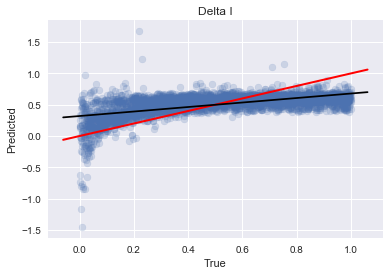

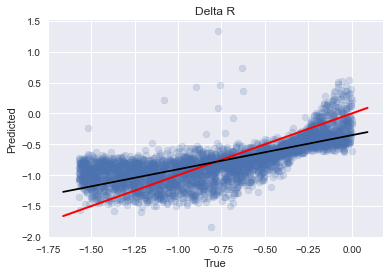

In [6]:
#Initialize and fit OLS model for deltaI 
model_OLS_I_pi = sm.OLS(Y2_train['deltaI'], X2_train)
model_OLS_R_pi = sm.OLS(Y2_train['deltaR'], X2_train)

results_OLS_I_pi = model_OLS_I_pi.fit()
results_OLS_R_pi = model_OLS_R_pi.fit()

#Make predictions on testing data
predictions_OLS_I_pi = results_OLS_I_pi.predict(X2_test) # make the predictions by the model
predictions_OLS_R_pi = results_OLS_R_pi.predict(X2_test)

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y2_test['deltaI'], predictions_OLS_I_pi,'Delta I')
plotSummary(Y2_test['deltaR'], predictions_OLS_R_pi, 'Delta R')

myResiduals(Y2_test['deltaI'], predictions_OLS_I_pi)
myResiduals(Y2_test['deltaR'], predictions_OLS_R_pi)



### spec points and peak info

 
RMSE on test data: 0.23685812110501875 for  Delta I
R^2 Score on test data: 0.33182418628595134 for Delta I
 
RMSE on test data: 0.31745274977132487 for  Delta R
R^2 Score on test data: 0.5011039884264956 for Delta R
The average residual for predict: 0.1879
Residual is this percent of predict range 4.218 %
The average residual for predict: 0.2406
Residual is this percent of predict range 4.01 %


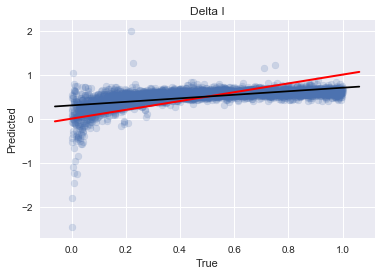

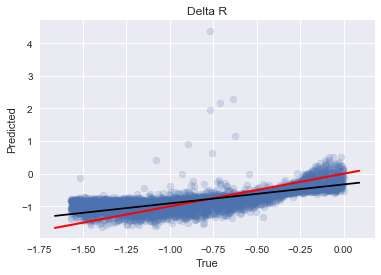

In [7]:
#Initialize and fit OLS model for deltaI 
model_OLS_I_both = sm.OLS(Y_train['deltaI'], X_train)
model_OLS_R_both = sm.OLS(Y_train['deltaR'], X_train)

results_OLS_I_both = model_OLS_I_both.fit()
results_OLS_R_both = model_OLS_R_both.fit()

#Make predictions on testing data
predictions_OLS_I_both = results_OLS_I_both.predict(X_test) # make the predictions by the model
predictions_OLS_R_both = results_OLS_R_both.predict(X_test)

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y_test['deltaI'], predictions_OLS_I_both,'Delta I')
plotSummary(Y_test['deltaR'], predictions_OLS_R_both, 'Delta R')

myResiduals(Y_test['deltaI'], predictions_OLS_I_both)
myResiduals(Y_test['deltaR'], predictions_OLS_R_both)

## Decision Tree

### spec points

 
RMSE on test data: 0.20025357897435941 for  deltaI Depth 60
R^2 Score on test data: 0.5223885115983318 for deltaI Depth 60
 
RMSE on test data: 0.3116971670094988 for  deltaR Depth 60
R^2 Score on test data: 0.5190304796203362 for deltaR Depth 60


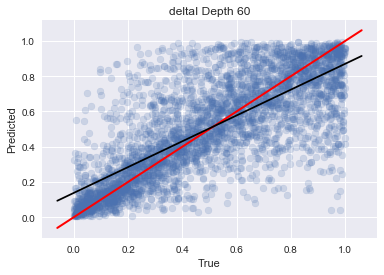

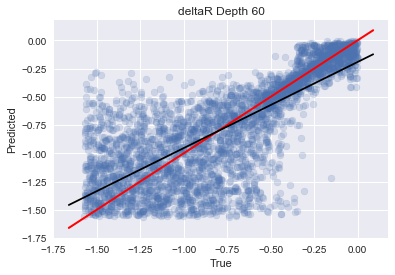

In [8]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])


### peak info

 
RMSE on test data: 0.09546595351853017 for  deltaI Depth 60
R^2 Score on test data: 0.8914546506389271 for deltaI Depth 60
 
RMSE on test data: 0.18825294181052024 for  deltaR Depth 60
R^2 Score on test data: 0.8245572651471195 for deltaR Depth 60


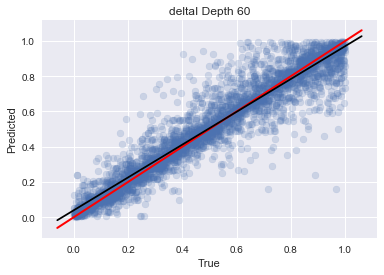

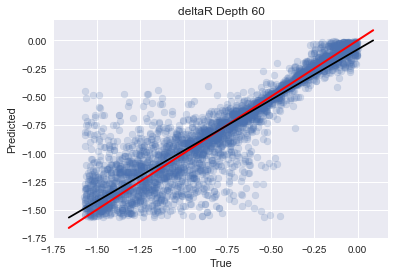

In [9]:
#Initialize the model
rs = 42
regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_pi = regr_DT_pi.predict(X2_test)

#Plot results
plotSummary(Y2_test['deltaI'], predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])


### spec points and peak info

 
RMSE on test data: 0.12329657895149668 for  deltaI Depth 60
R^2 Score on test data: 0.8189426145499487 for deltaI Depth 60
 
RMSE on test data: 0.2191985848576826 for  deltaR Depth 60
R^2 Score on test data: 0.7621367560340437 for deltaR Depth 60


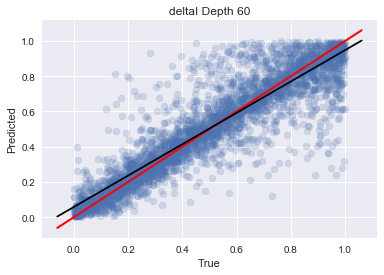

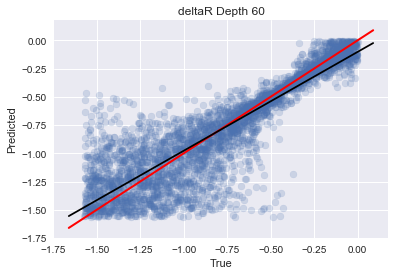

In [10]:
#Initialize the model
rs = 42
regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_both.fit(X_train, Y_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_both = regr_DT_both.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])


## Random Forest

### spec points

 
RMSE on test data: 0.15178905683384833 for  deltaI 10
R^2 Score on test data: 0.7255930439462811 for deltaI 10
 
RMSE on test data: 0.2263946795460997 for  deltaR 10
R^2 Score on test data: 0.7462627210852554 for deltaR 10


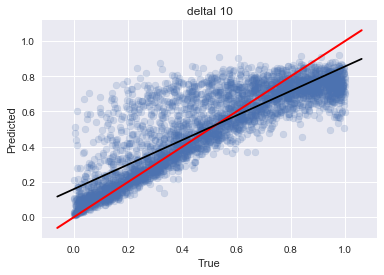

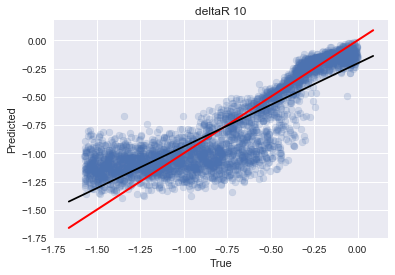

In [11]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI 10')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR 10')


### peak info

 
RMSE on test data: 0.0707739422897756 for  deltaI 10
R^2 Score on test data: 0.9403430609028485 for deltaI 10
 
RMSE on test data: 0.13787840869182352 for  deltaR 10
R^2 Score on test data: 0.9058881370836781 for deltaR 10


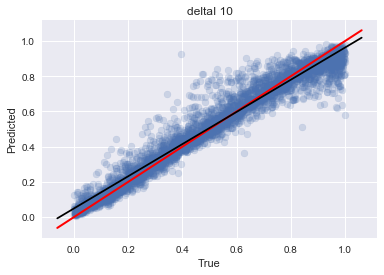

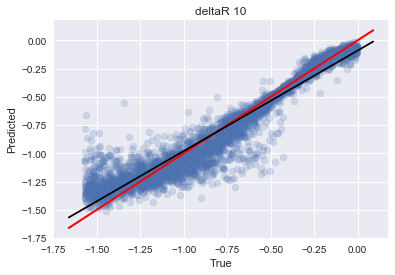

In [12]:
rs = 42
regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_pi = regr_RF_pi.fit(X2_train, Y2_train)

predictions_RF_pi = model_RF_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_RF_pi[:,0], 'deltaI 10')
plotSummary(Y2_test['deltaR'], predictions_RF_pi[:,1], 'deltaR 10')

### spec points and peak info

 
RMSE on test data: 0.08499599129071482 for  deltaI 10
R^2 Score on test data: 0.9139578848202359 for deltaI 10
 
RMSE on test data: 0.15864510292020764 for  deltaR 10
R^2 Score on test data: 0.875403688169581 for deltaR 10


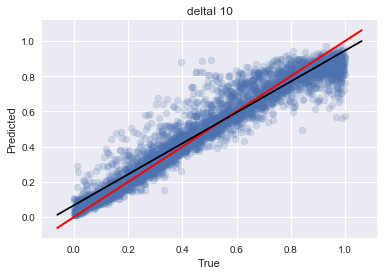

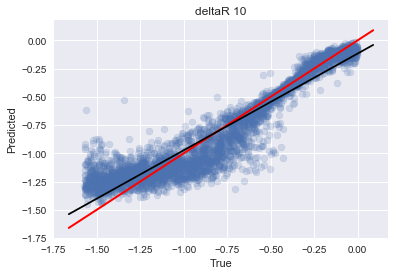

In [13]:
rs = 42
regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_both = regr_RF_both.fit(X_train, Y_train)

predictions_RF_both = model_RF_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_RF_both[:,0], 'deltaI 10')
plotSummary(Y_test['deltaR'], predictions_RF_both[:,1], 'deltaR 10')

## Independent Random Forests

### spec points


Score - Random Forest: 0.7417847661507642 for delta I/R 10
 
RMSE on test data: 0.22838364899364189 for  deltaI 10
R^2 Score on test data: 0.7417847661507642 for deltaI 10
 
RMSE on test data: 0.1506967995797667 for  deltaR 10
R^2 Score on test data: 0.7295280391010455 for deltaR 10


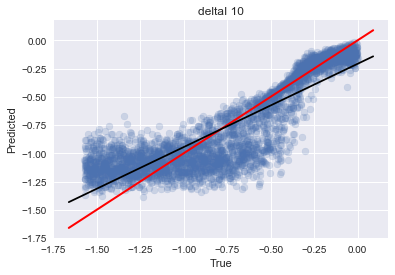

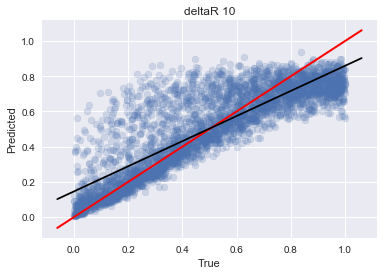

In [14]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for delta I/R 10')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaI 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaR 10')


### peak info


Score - Random Forest: 0.8848245682304128 for delta I/R 10
 
RMSE on test data: 0.15252955449794353 for  deltaI 10
R^2 Score on test data: 0.8848245682304128 for deltaI 10
 
RMSE on test data: 0.07544312739201606 for  deltaR 10
R^2 Score on test data: 0.9322118849566594 for deltaR 10


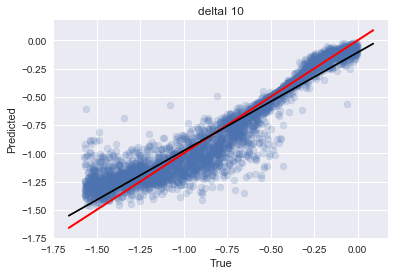

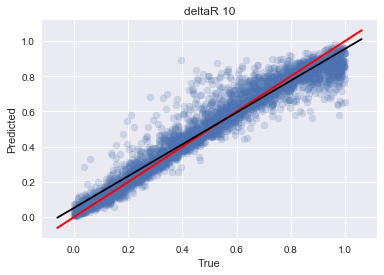

In [15]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_pi = regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_RF2_di_pi = regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])

predictions_RF2_dr_pi = model_RF2_dr_pi.predict(X2_test)
predictions_RF2_di_pi = model_RF2_di_pi.predict(X2_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_pi.score(X2_test, Y2_test['deltaR']), 'for delta I/R 10')

plotSummary(Y2_test['deltaR'], predictions_RF2_dr_pi, 'deltaI 10')
plotSummary(Y2_test['deltaI'], predictions_RF2_di_pi, 'deltaR 10')

### spec points and peak info


Score - Random Forest: 0.8217386756408565 for delta I/R 10
 
RMSE on test data: 0.18975911299839118 for  deltaI 10
R^2 Score on test data: 0.8217386756408565 for deltaI 10
 
RMSE on test data: 0.09502660663834622 for  deltaR 10
R^2 Score on test data: 0.8924514316520651 for deltaR 10


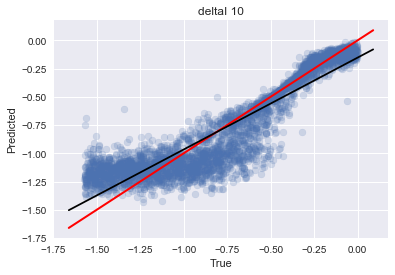

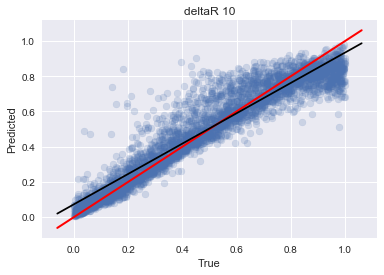

In [16]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_both = regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
model_RF2_di_both = regr_RF2_di_both.fit(X_train, Y_train['deltaI'])

predictions_RF2_dr_both = model_RF2_dr_both.predict(X_test)
predictions_RF2_di_both = model_RF2_di_both.predict(X_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_both.score(X_test, Y_test['deltaR']), 'for delta I/R 10')

plotSummary(Y_test['deltaR'], predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], predictions_RF2_di_both, 'deltaR 10')

## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.1540525365795638 for  AdaBoost Delta I
R^2 Score on test data: 0.717348106751908 for AdaBoost Delta I
 
RMSE on test data: 0.23937056279855592 for  AdaBoost Delta R
R^2 Score on test data: 0.7163431163992304 for AdaBoost Delta R
Delta I AdaBoost Score: 0.717348106751908
Delta R AdaBoost Score: 0.7163431163992304


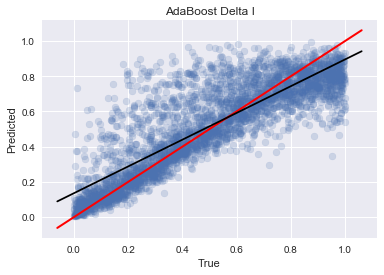

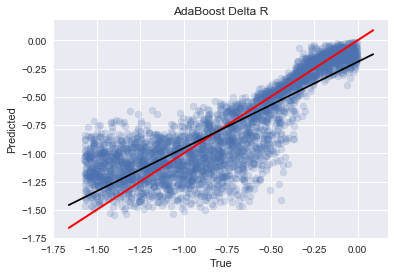

In [17]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))


### peak info

 
RMSE on test data: 0.07718583944529729 for  AdaBoost Delta I
R^2 Score on test data: 0.9290439460998065 for AdaBoost Delta I
 
RMSE on test data: 0.15493709634082287 for  AdaBoost Delta R
R^2 Score on test data: 0.8811599924540081 for AdaBoost Delta R


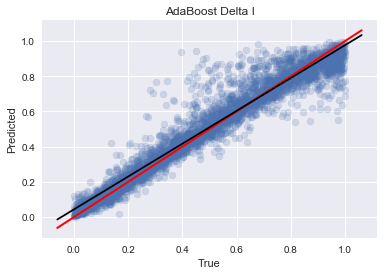

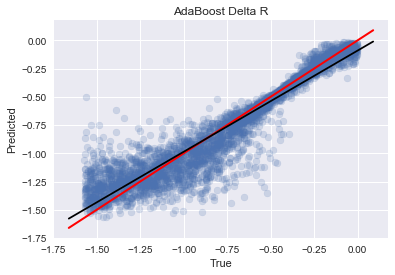

In [18]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_pi = regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_AB_dr_pi = regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])

predictions_AB_di_pi = model_AB_di_pi.predict(X2_test)
predictions_AB_dr_pi = model_AB_dr_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_AB_di_pi, 'AdaBoost Delta I')
plotSummary(Y2_test['deltaR'], predictions_AB_dr_pi, 'AdaBoost Delta R')


### spec points and peak info

 
RMSE on test data: 0.10083780877729236 for  AdaBoost Delta I
R^2 Score on test data: 0.8788953019791322 for AdaBoost Delta I
 
RMSE on test data: 0.20104607309806746 for  AdaBoost Delta R
R^2 Score on test data: 0.7999018677455516 for AdaBoost Delta R


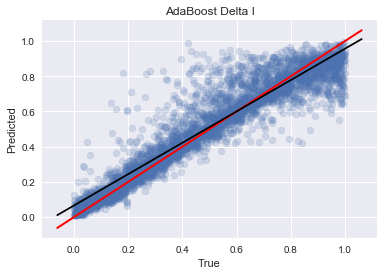

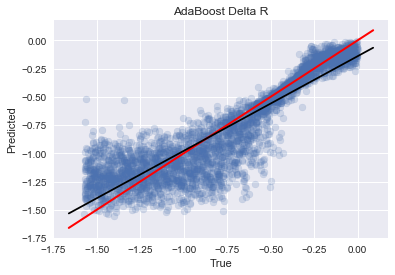

In [19]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_both = regr_AB_di_both.fit(X_train, Y_train['deltaI'])
model_AB_dr_both = regr_AB_dr_both.fit(X_train, Y_train['deltaR'])

predictions_AB_di_both = model_AB_di_both.predict(X_test)
predictions_AB_dr_both = model_AB_dr_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_AB_di_both, 'AdaBoost Delta I')
plotSummary(Y_test['deltaR'], predictions_AB_dr_both, 'AdaBoost Delta R')


## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.19303629083231907 for  GradientBoost Delta I
R^2 Score on test data: 0.5561950727491438 for GradientBoost Delta I
 
RMSE on test data: 0.2963440255100261 for  GradientBoost Delta R
R^2 Score on test data: 0.5652453883902906 for GradientBoost Delta R


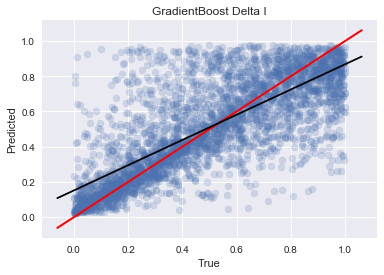

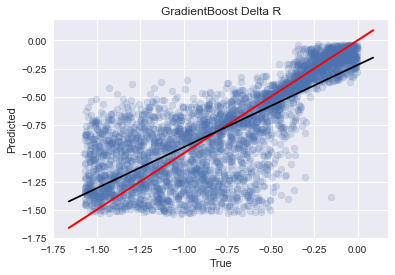

In [20]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R')


### peak info

 
RMSE on test data: 0.09921925184662427 for  GradientBoost Delta I
R^2 Score on test data: 0.8827518261243641 for GradientBoost Delta I
 
RMSE on test data: 0.2013116121247809 for  GradientBoost Delta R
R^2 Score on test data: 0.7993729446810727 for GradientBoost Delta R


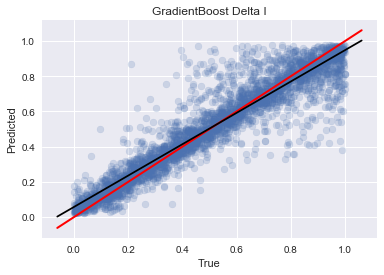

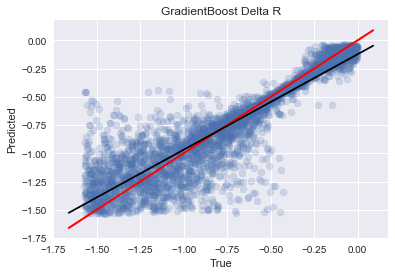

In [21]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_pi = regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])

model_GB_dr_pi = regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])

predictions_GB_di_pi = model_GB_di_pi.predict(X2_test)
predictions_GB_dr_pi = model_GB_dr_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_GB_di_pi, 'GradientBoost Delta I')
plotSummary(Y2_test['deltaR'], predictions_GB_dr_pi, 'GradientBoost Delta R')


### spec points and peak info

 
RMSE on test data: 0.11869948613195745 for  GradientBoost Delta I
R^2 Score on test data: 0.8321923061087418 for GradientBoost Delta I
 
RMSE on test data: 0.25474257271770584 for  GradientBoost Delta R
R^2 Score on test data: 0.6787412933970539 for GradientBoost Delta R


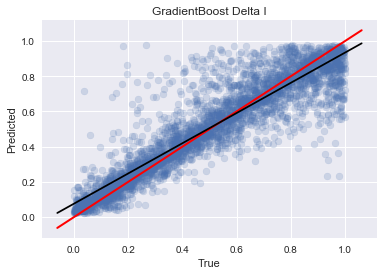

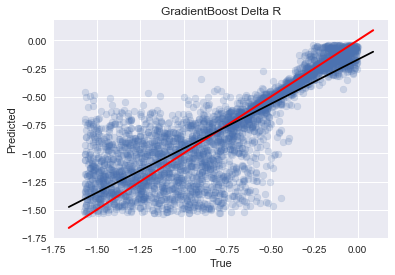

In [22]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_both = regr_GB_di_both.fit(X_train, Y_train['deltaI'])

model_GB_dr_both = regr_GB_dr_both.fit(X_train, Y_train['deltaR'])

predictions_GB_di_both = model_GB_di_both.predict(X_test)
predictions_GB_dr_both = model_GB_dr_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_GB_di_both, 'GradientBoost Delta I')
plotSummary(Y_test['deltaR'], predictions_GB_dr_both, 'GradientBoost Delta R')



## Testing the Models on the Experimental Data



In [47]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names

col_names_exp_both = col_names_both[2:]

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_peakinfo.csv', header = None, names = col_names3)

In [50]:
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
col_names1a = energy_names[50:]
exp_data_sp = exp_data_sp[col_names1a]
exp_data_sp

,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,E_-284_mV,E_-282_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.63866,0.64322,0.6455,0.6487,0.65752,0.66493,0.67365,0.68098,0.69691,0.70971,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [59]:
peak_names2 = ['peak2', 'peak3', 'peak4']
pi_names = peak_names2 + locs_names + width_names + prom_names
exp_data_pi = exp_data_pi[pi_names]
exp_data_pi

,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,1.9262,1.8662,1.4495,-0.362,-0.242,-0.074,0.134,0.026521,0.032045,0.039422,0.04612,1.1543,1.2902,1.1855,0.57098


In [66]:
subset = 5 
energy_names2 = energy_names[50::subset]
exp_data_sp2 = exp_data_sp[energy_names2]
exp_data_both = exp_data_sp2.join(exp_data_pi, how = 'left')
exp_data_both


,E_-300_mV,E_-290_mV,E_-280_mV,E_-270_mV,E_-260_mV,E_-250_mV,E_-240_mV,E_-230_mV,E_-220_mV,E_-210_mV,...,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,0.63866,0.66493,0.73142,0.8833,1.2683,1.7875,1.8818,1.3979,0.98272,0.78177,...,-0.074,0.134,0.026521,0.032045,0.039422,0.04612,1.1543,1.2902,1.1855,0.57098


In [67]:
pred_phase_OLS_R_sp = results_OLS_R_sp.predict(exp_data_sp)
pred_phase_OLS_I_sp = results_OLS_I_sp.predict(exp_data_sp)

pred_phase_OLS_R_pi = results_OLS_R_pi.predict(exp_data_pi)
pred_phase_OLS_I_pi = results_OLS_I_pi.predict(exp_data_pi)

pred_phase_OLS_R_both = results_OLS_R_both.predict(exp_data_both)
pred_phase_OLS_I_both = results_OLS_I_both.predict(exp_data_both)

pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T

pred_phase_DT_pi = np.append(regr_DT_pi.predict(exp_data_pi), 
                            r2_score(Y1_test['deltaI'], predictions_DT_pi[:,0])).reshape(3,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['deltaR'], predictions_DT_pi[:,1])).reshape(4,1).T
#pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['scale_factor'], y_pred_DT[:,2]))

pred_phase_DT_both = np.append(regr_DT_both.predict(exp_data_both), 
                            r2_score(Y_test['deltaI'], predictions_DT_both[:,0])).reshape(3,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['deltaR'], predictions_DT_both[:,1])).reshape(4,1).T

pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)
pred_phase_RF_pi = regr_RF_pi.predict(exp_data_pi)
pred_phase_RF_both = regr_RF_both.predict(exp_data_both)

pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)

pred_phase_AB_R_pi = model_AB_dr_pi.predict(exp_data_pi)
pred_phase_AB_I_pi = model_AB_di_pi.predict(exp_data_pi)

pred_phase_AB_R_both = model_AB_dr_both.predict(exp_data_both)
pred_phase_AB_I_both = model_AB_di_both.predict(exp_data_both)

pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)

pred_phase_GB_di_pi = model_GB_di_pi.predict(exp_data_pi)
pred_phase_GB_dr_pi = model_GB_dr_pi.predict(exp_data_pi)

pred_phase_GB_di_both = model_GB_di_both.predict(exp_data_both)
pred_phase_GB_dr_both = model_GB_dr_both.predict(exp_data_both)

pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)

pred_phase_IRF_di_pi = model_RF2_di_pi.predict(exp_data_pi)
pred_phase_IRF_dr_pi = model_RF2_dr_pi.predict(exp_data_pi)

pred_phase_IRF_di_both = model_RF2_di_both.predict(exp_data_both)
pred_phase_IRF_dr_both = model_RF2_dr_both.predict(exp_data_both)

predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree spec points'])

new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], name = 'Decision Tree Peak Info')
predictedPhases = predictedPhases.append(new_test)

new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], name = 'Decision Tree Spec Points and peak info')
predictedPhases = predictedPhases.append(new_1)

predictedPhases.loc['OLS spec points'] = (pred_phase_OLS_I_sp[0], pred_phase_OLS_R_sp[0], r2_score(Y1_test['deltaI'],predictions_OLS_I_sp ), r2_score(Y1_test['deltaR'],predictions_OLS_R_sp ))
predictedPhases.loc['OLS peak info'] = (pred_phase_OLS_I_pi[0], pred_phase_OLS_R_pi[0], r2_score(Y2_test['deltaI'], predictions_OLS_I_pi), r2_score(Y2_test['deltaR'], predictions_OLS_R_pi))
predictedPhases.loc['OLS spec points and peak info'] = (pred_phase_OLS_I_both[0], pred_phase_OLS_R_both[0], r2_score(Y_test['deltaI'], predictions_OLS_I_both), r2_score(Y_test['deltaR'], predictions_OLS_R_both))

predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0]), r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1]))
predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], r2_score(Y2_test['deltaI'], predictions_RF_pi[:,0]), r2_score(Y2_test['deltaR'], predictions_RF_pi[:,1]))
predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], r2_score(Y_test['deltaI'], predictions_RF_both[:,0]), r2_score(Y_test['deltaR'], predictions_RF_both[:,1]))


predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0],r2_score(Y1_test['deltaI'], predictions_AB_di_sp), r2_score(Y1_test['deltaR'], predictions_AB_dr_sp))
predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0],r2_score(Y2_test['deltaI'], predictions_AB_di_pi), r2_score(Y2_test['deltaR'], predictions_AB_dr_pi))
predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0],r2_score(Y_test['deltaI'], predictions_AB_di_both), r2_score(Y_test['deltaR'], predictions_AB_dr_both))

predictedPhases.loc['Gradient Boosting spec Points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0],  r2_score(Y1_test['deltaI'], predictions_GB_di_sp), r2_score(Y1_test['deltaR'], predictions_GB_dr_sp))
predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0], r2_score(Y2_test['deltaI'], predictions_GB_di_pi), r2_score(Y2_test['deltaR'], predictions_GB_dr_pi))
predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], pred_phase_GB_dr_both[0], r2_score(Y_test['deltaI'], predictions_GB_di_both), r2_score(Y_test['deltaR'], predictions_GB_dr_both))


predictedPhases.loc['Independent Random Forests spec Points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  r2_score(Y1_test['deltaI'], predictions_RF2_di_sp ), r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp))
predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0], r2_score(Y2_test['deltaI'], predictions_RF2_di_pi), r2_score(Y2_test['deltaR'], predictions_RF2_dr_pi))
predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0], r2_score(Y_test['deltaI'], predictions_RF2_di_both), r2_score(Y_test['deltaR'], predictions_RF2_dr_both))


predictedPhases2 = predictedPhases.drop(['OLS spec points', 'OLS peak info', 'OLS spec points and peak info'], axis = 0)
predictedPhases2

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,0.231120,-0.024866,0.522389,0.519030
Decision Tree Peak Info,0.567870,-0.050459,0.891455,0.824557
Decision Tree Spec Points and peak info,0.099779,-0.009802,0.818943,0.762137
Random Forest spec points,0.195584,-0.104943,0.725593,0.746263
Random Forest peak info,0.473000,-0.075347,0.940343,0.905888
Random Forest spec points and peak info,0.168303,-0.055191,0.913958,0.875404
AdaBoost spec points,0.200160,-0.066756,0.717348,0.716343
AdaBoost peak info,0.575650,-0.024468,0.929044,0.881160
AdaBoost spec points and peak info,0.303390,-0.103930,0.878895,0.799902
Gradient Boosting spec Points,0.117723,-0.148335,0.556195,0.565245


In [68]:
#Since this prediction has a score less than 0.99, we will exclude it. 
GoodPredictedPhases = predictedPhases2

deltaI_1 = (GoodPredictedPhases['deltaI']*GoodPredictedPhases['deltaI score']).mean()
deltaR_1 = (GoodPredictedPhases['deltaR']*GoodPredictedPhases['deltaR score']).mean()

print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')


The weighted average for the predicted phase is:  -0.04991009988050255  +  0.24675628735713465 *i


In [69]:
predictedPhases[['deltaI', 'deltaR']].to_csv('Model_Results/Hexagon/predictions_v9_JulyDispersion_deleteFirstPeak_threekinds.csv')
predictedPhases[['deltaI score', 'deltaR score']].to_csv('Model_Results/Hexagon/scores_v9_JulyDispersion_deleteFirstPeak_threekinds.csv')



In [70]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,0.231120,-0.024866,0.522389,0.519030
Decision Tree Peak Info,0.567870,-0.050459,0.891455,0.824557
Decision Tree Spec Points and peak info,0.099779,-0.009802,0.818943,0.762137
OLS spec points,0.508314,-0.722647,-11.655103,-2.209264
OLS peak info,0.489692,-0.538374,0.336544,0.534027
OLS spec points and peak info,44.466479,-13.898130,0.331824,0.501104
Random Forest spec points,0.195584,-0.104943,0.725593,0.746263
Random Forest peak info,0.473000,-0.075347,0.940343,0.905888
Random Forest spec points and peak info,0.168303,-0.055191,0.913958,0.875404
AdaBoost spec points,0.200160,-0.066756,0.717348,0.716343
